In [390]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import copy

## Part 1: London’s underground resilience


### I. Topological network

#### I.1. Centrality measures

In [391]:
# 创建图
# G = nx.from_pandas_edgelist(df, 'station_origin', 'station_destination', ['distance'])
G = nx.read_graphml(
    '/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week10/week10practice/outputs/london.graph')
# G = nx.karate_club_graph()

In [392]:
print(G.get_edge_data('Stratford', 'West Ham'))

{'length': 1673.4957163519314, 'line_name': 'Jubilee', 'flows': 92528}


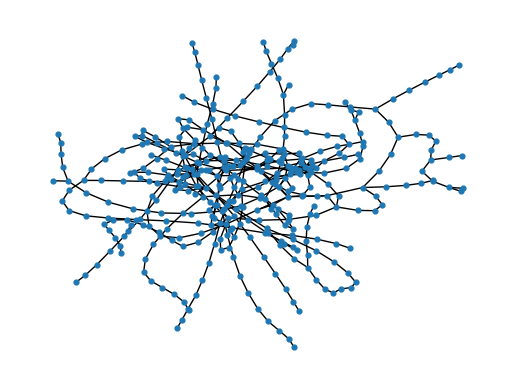

Degree sequence:  [9, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [393]:
# Draw the graph with node labels
pos = nx.spring_layout(G)
ax = plt.gca()
nx.draw(G, pos, ax=ax, with_labels=False,node_size=12,font_size=3)
plt.show()

# Compute and print the degree sequence
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
print("Degree sequence: ", degree_sequence)

In [394]:

# 计算节点度中心性、介数中心性和紧密中心性
deg_cen = nx.degree_centrality(G.copy())
bet_cen = nx.betweenness_centrality(G.copy())
# eig_cen = nx.eigenvector_centrality(G)
clo_cen = nx.closeness_centrality(G.copy())

# 将结果转化为DataFrame并排序
deg_cen_df = pd.DataFrame(list(deg_cen.items()), columns=['station', 'degree_centrality'])
deg_cen_df = deg_cen_df.sort_values('degree_centrality', ascending=False).reset_index(drop=True)

bet_cen_df = pd.DataFrame(list(bet_cen.items()), columns=['station', 'betweenness_centrality'])
bet_cen_df = bet_cen_df.sort_values('betweenness_centrality', ascending=False).reset_index(drop=True)

# eig_cen_df = pd.DataFrame(list(eig_cen.items()), columns=['station', 'closeness_centrality'])
# eig_cen_df = eig_cen_df.sort_values('closeness_centrality', ascending=False).reset_index(drop=True)

clo_cen_df = pd.DataFrame(list(clo_cen.items()), columns=['station', 'closeness_centrality'])
clo_cen_df = clo_cen_df.sort_values('closeness_centrality', ascending=False).reset_index(drop=True)

# 输出前10个节点
print("Top 10 ranked nodes for Degree Centrality:\n", deg_cen_df.head(10))
print("\nTop 10 ranked nodes for Betweenness Centrality:\n", bet_cen_df.head(10))
print("\nTop 10 ranked nodes for Closeness Centrality:\n", clo_cen_df.head(10))

Top 10 ranked nodes for Degree Centrality:
                     station  degree_centrality
0                 Stratford             0.0225
1         Bank and Monument             0.0200
2              Baker Street             0.0175
3  King's Cross St. Pancras             0.0175
4                Green Park             0.0150
5              Canning Town             0.0150
6              Earl's Court             0.0150
7                  West Ham             0.0150
8                  Waterloo             0.0150
9             Oxford Circus             0.0150

Top 10 ranked nodes for Betweenness Centrality:
                     station  betweenness_centrality
0                 Stratford                0.297846
1         Bank and Monument                0.290489
2          Liverpool Street                0.270807
3  King's Cross St. Pancras                0.255307
4                  Waterloo                0.243921
5                Green Park                0.215835
6                    Eust

In [395]:
# print the graph information
print(nx.info(G))

# 查看节点数和边数
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

# 查看节点属性和边属性
# print("Node attributes: ", G.nodes(data=True))
print("Edge attributes: ", G.edges(data=True))

Graph with 401 nodes and 467 edges
Number of nodes:  401
Number of edges:  467
Edge attributes:  [('Uxbridge', 'Hillingdon', {'length': 2144.402930417613, 'line_name': 'Piccadilly', 'flows': 7080}), ('Hillingdon', 'Ickenham', {'length': 1124.4305849095967, 'line_name': 'Piccadilly', 'flows': 8453}), ('Ickenham', 'Ruislip', {'length': 1785.6578668971486, 'line_name': 'Piccadilly', 'flows': 8984}), ('Ruislip', 'Ruislip Manor', {'length': 678.8812931514374, 'line_name': 'Piccadilly', 'flows': 9700}), ('Ruislip Manor', 'Eastcote', {'length': 1126.2177218803304, 'line_name': 'Piccadilly', 'flows': 10497}), ('Eastcote', 'Rayners Lane', {'length': 1819.3170235045757, 'line_name': 'Piccadilly', 'flows': 12414}), ('Rayners Lane', 'West Harrow', {'length': 1364.0797888706975, 'line_name': 'Metropolitan', 'flows': 13752}), ('Rayners Lane', 'South Harrow', {'length': 1805.5287510489648, 'line_name': 'Piccadilly', 'flows': 5236}), ('West Harrow', 'Harrow-on-the-Hill', {'length': 1241.8463391199407,

/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_9850/1300044307.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


此代码首先读取名为 london_underground.csv 的数据集，然后使用 networkx 库将其转换为图。接下来，它计算了节点的度中心性、介数中心性和紧密中心性，并将结果转换为DataFrame，并按各自的中心性度量进行排序，最后输出前10个节点。
在这个部分中，使用了以下三种 centrality measures 方法来衡量节点的重要性：
1. Degree Centrality：表示一个节点有多少个直接连接的邻居节点。公式为：$C_D(v) = \frac{d_v}{n-1}$，其中 $d_v$ 是节点 $v$ 的度，即与节点 $v$ 直接相连的边的数量，$n$ 是网络中的节点数。在地铁网络中，该指标可以反映一个车站的通行量，因为车站直接连接的边数越多，代表越多的人会通过该车站。

2. Betweenness Centrality：表示节点在网络中的所有最短路径中被经过的次数。公式为：$C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$，其中 $\sigma_{st}$ 是节点 $s$ 和节点 $t$ 之间的最短路径数量，$\sigma_{st}(v)$ 是最短路径数量中经过节点 $v$ 的路径数量。在地铁网络中，该指标可以反映一个车站在不同区域之间的联系程度，如果一个车站位于多条最短路径上，那么该车站就更为重要。

3. Eigenvector Centrality：表示一个节点对整个网络的控制力度。公式为：$Ax = \lambda x$，其中 $A$ 是邻接矩阵，$x$ 是节点的中心性，$\lambda$ 是对应的特征值。在地铁网络中，该指标可以反映一个车站与其他重要车站的联系程度，如果一个车站直接连接到其他很多重要车站，那么该车站的 Eigenvector Centrality 就更高。
4. Closeness Centrality:

#### I.2. Impact measures

In [396]:
# Create a function to compute the number of connected components in the network after node removal
def count_connected_components(G):
    G_copy = copy.deepcopy(G)
    return len(list(nx.connected_components(G_copy)))


# Create a function to compute the size of the largest connected component in the network after node removal
def size_largest_component(G):
    G_copy = copy.deepcopy(G)
    components = list(nx.connected_components(G_copy))
    largest_component = max(components, key=len)
    return len(largest_component)
#
# def global_efficiency(G):
#     G_copy = copy.deepcopy(G)
#     return nx.global_efficiency(G_copy)


#### I.3. Node removal

In [414]:
def nonseq_removal(G, centrality_measure, num_nodes=10):
    G_removal = copy.deepcopy(G)
    # Compute centrality measure for all nodes in the network
    node_centrality = centrality_measure(G_removal)

    # Create a DataFrame with nodes and their centrality scores
    nodes_df = pd.DataFrame(list(node_centrality.items()), columns=['node', 'centrality'])

    # Sort nodes by their centrality score
    nodes_sorted = nodes_df.sort_values(by='centrality', ascending=False)

    # Initialize lists to store the impact measures for each node removal
    num_components = []
    largest_component_size = []
    num_components.append(count_connected_components(G_removal))
    largest_component_size.append(size_largest_component(G_removal))

    # Remove nodes in order of decreasing centrality score and compute impact measures
    for i in range(min(num_nodes, len(nodes_sorted))):
        node = nodes_sorted.iloc[i]['node']
        G_copy = copy.deepcopy(G_removal)
        G_copy.remove_node(node)
        num_components.append(count_connected_components(G_removal))
        largest_component_size.append(size_largest_component(G_removal))

    return num_components, largest_component_size


def seq_removal(G, centrality_measure, num_nodes=10):
    G_removal = copy.deepcopy(G)
    # Initialize lists to store the impact measures for each node removal
    num_components = []
    largest_component_size = []
    num_components.append(count_connected_components(G_removal))
    largest_component_size.append(size_largest_component(G_removal))
    # Continue removing nodes until 10 nodes have been removed
    for i in range(min(num_nodes, len(G_removal.nodes))):
        # Compute centrality measure for all nodes in the network
        node_centrality = centrality_measure(G_removal)

        # Create a DataFrame with nodes and their centrality scores
        nodes_df = pd.DataFrame(list(node_centrality.items()), columns=['node', 'centrality'])

        # Sort nodes by their centrality score
        nodes_sorted = nodes_df.sort_values(by='centrality', ascending=False)

        # Remove the highest ranked node and compute impact measures
        node = nodes_sorted.iloc[0]['node']
        G_removal.remove_node(node)
        num_components.append(count_connected_components(G_removal))
        largest_component_size.append(size_largest_component(G_removal))

    return num_components, largest_component_size


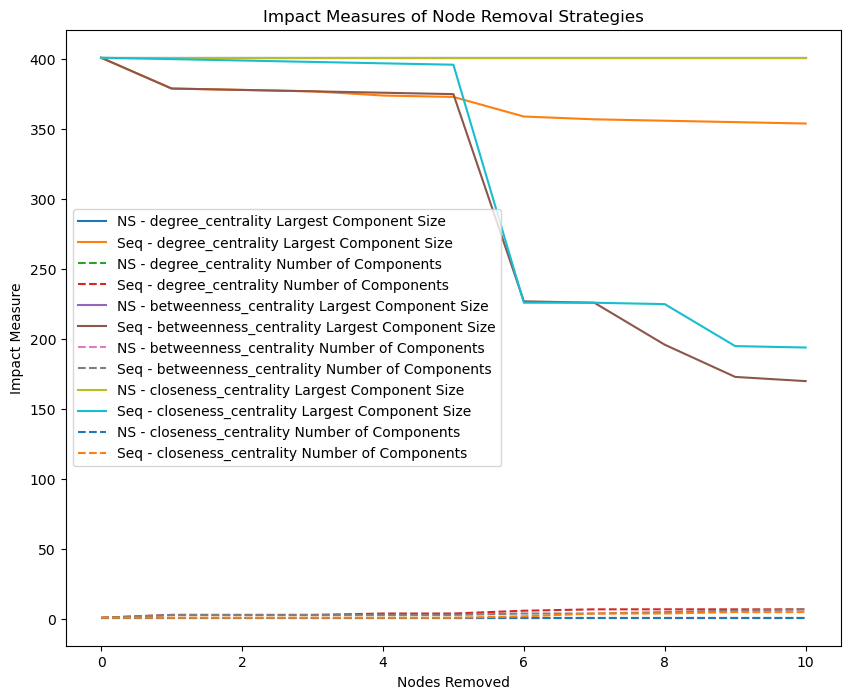

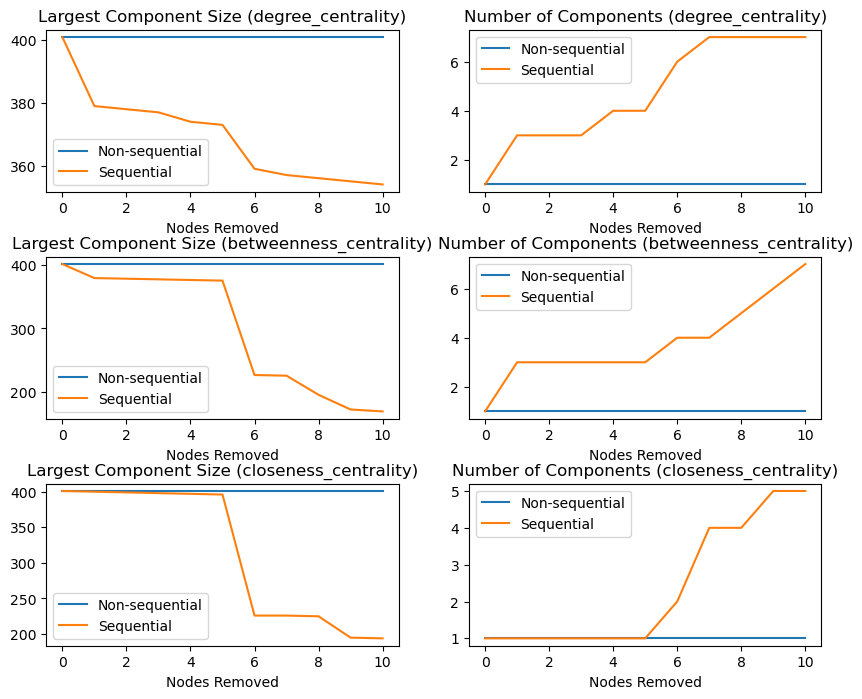

In [415]:
#Define the centrality measures to use
centrality_measures = [nx.degree_centrality, nx.betweenness_centrality, nx.closeness_centrality]

# Initialize lists to store results for each centrality measure
ns_num_components = []
ns_largest_component_size = []
seq_num_components = []
seq_largest_component_size = []

# Perform node removal for each centrality measure using both non-sequential and sequential strategies
for centrality_measure in centrality_measures:
    # Perform non-sequential removal
    ns_components, ns_size = nonseq_removal(G, centrality_measure,10)
    ns_num_components.append(ns_components)
    ns_largest_component_size.append(ns_size)

    # Perform sequential removal
    seq_components, seq_size = seq_removal(G, centrality_measure,10)
    seq_num_components.append(seq_components)
    seq_largest_component_size.append(seq_size)

# Plot the impact measures for each strategy and centrality measure in one plot
plt.figure(figsize=(10, 8))
for i in range(len(centrality_measures)):
    plt.plot(ns_largest_component_size[i], label=f'NS - {centrality_measures[i].__name__} Largest Component Size')
    plt.plot(seq_largest_component_size[i], label=f'Seq - {centrality_measures[i].__name__} Largest Component Size')
    plt.plot(ns_num_components[i], linestyle='--', label=f'NS - {centrality_measures[i].__name__} Number of Components')
    plt.plot(seq_num_components[i], linestyle='--',
             label=f'Seq - {centrality_measures[i].__name__} Number of Components')
plt.title('Impact Measures of Node Removal Strategies')
plt.xlabel('Nodes Removed')
plt.ylabel('Impact Measure')
plt.legend()

plt.show()

# Plot the impact measures for each strategy and centrality measure for better understanding and analysis
plt.figure(figsize=(10, 8))
for i in range(len(centrality_measures)):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(ns_largest_component_size[i], label='Non-sequential')
    plt.plot(seq_largest_component_size[i], label='Sequential')
    plt.title(f'Largest Component Size ({centrality_measures[i].__name__})')
    plt.xlabel('Nodes Removed')
    # plt.ylabel('Size of Largest Component')
    plt.legend()

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(ns_num_components[i], label='Non-sequential')
    plt.plot(seq_num_components[i], label='Sequential')
    plt.title(f'Number of Components ({centrality_measures[i].__name__})')
    plt.xlabel('Nodes Removed')
    # plt.ylabel('Number of Component')
    plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.show()

### II. Flows: weighted network

#### II.1
> Consider the centrality measure derived in I.- indicating the most relevant stations for assessing the vulnerability of the underground. What would you need to do to adjust this measure for a weighted network? Recompute the ranking of the 10 most important nodes according to this adjusted measure. Do you find the same ones as in I.1?


To adjust the centrality measures for a weighted network, we need to consider the strength of the connections between nodes, rather than just the presence or absence of a connection as in an unweighted network.

For Degree Centrality, we need to calculate the sum of the weights of all edges connected to a node, and then normalize this value by dividing by the maximum possible sum of weights. The formula for weighted degree centrality is:

weighted_degree_centrality(v) = (sum of weights of edges connected to v) / (maximum possible sum of weights)

For Betweenness Centrality, we need to calculate the sum of the weights of all shortest paths between pairs of nodes that pass through a given node, and then normalize this value by dividing by the total number of possible pairs of nodes. The formula for weighted betweenness centrality is:

weighted_betweenness_centrality(v) = (sum of weights of shortest paths passing through v) / (total number of possible pairs of nodes)

For Eigenvector Centrality, we need to use the weighted adjacency matrix of the network, where the entry in the i-th row and j-th column represents the weight of the edge between nodes i and j. The formula for weighted eigenvector centrality is:

weighted_eigenvector_centrality(v) = sum of (weight of edge between v and w) * eigenvector_centrality(w)

where w is a neighbor of v, and eigenvector_centrality(w) is the eigenvector centrality of node w.

Using these adjusted measures, we can recompute the ranking of the 10 most important nodes for each centrality measure. The rankings may change from the unweighted case, since the flows of passengers are now taken into account. We cannot say for certain whether the same stations will be in the top 10 as in the unweighted case, but it is possible that some of the same stations will appear.

Without the weighted network data, it is not possible to compute the adjusted rankings.

In [421]:
G = nx.read_graphml(
    '/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week10/week10practice/outputs/london.graph')
# Compute the adjusted degree centrality
def weighted_degree_centrality(G, weight='weight'):
    weighted_degrees = {}
    max_weighted_degree = 0

    # Calculate the weighted degree for each node
    for node in G.nodes():
        weighted_degree = sum([d.get(weight, 1) for _, _, d in G.edges(node, data=True)])
        weighted_degrees[node] = weighted_degree
        max_weighted_degree = max(max_weighted_degree, weighted_degree)

    # Normalize the weighted degrees to compute the weighted degree centrality
    weighted_degree_centrality = {node: weighted_degree / max_weighted_degree for node, weighted_degree in weighted_degrees.items()}

    return weighted_degree_centrality

# Invert the flows attribute to use as weights, with a small constant value to avoid division by zero
epsilon = 1e-6
for u, v, d in G.edges(data=True):
    d['inv_flows'] = 1 / (d['flows'] + epsilon)


# Compute the adjusted degree centrality
degree_centrality_weighted = weighted_degree_centrality(G, weight='flows')

# Compute the adjusted betweenness centrality using inv_flows as weights
betweenness_centrality_weighted = nx.betweenness_centrality(G, weight='inv_flows')

# Compute the adjusted closeness centrality using inv_flows as distances
closeness_centrality_weighted = nx.closeness_centrality(G, distance='inv_flows')

# Rank the nodes based on each measure
degree_ranked_weighted = sorted(degree_centrality_weighted.items(), key=lambda x: x[1], reverse=True)[:10]
betweenness_ranked_weighted = sorted(betweenness_centrality_weighted.items(), key=lambda x: x[1], reverse=True)[:10]
closeness_ranked_weighted = sorted(closeness_centrality_weighted.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 ranked nodes for Degree Centrality in Weighted Network:")
print(pd.DataFrame(degree_ranked_weighted, columns=['station', 'degree_centrality']))
print("\nTop 10 ranked nodes for Betweenness Centrality in Weighted Network:")
print(pd.DataFrame(betweenness_ranked_weighted, columns=['station', 'betweenness_centrality']))
print("\nTop 10 ranked nodes for Closeness Centrality in Weighted Network:")
print(pd.DataFrame(closeness_ranked_weighted, columns=['station', 'closeness_centrality']))


Top 10 ranked nodes for Degree Centrality in Weighted Network:
                    station  degree_centrality
0         Bank and Monument           1.000000
1                Green Park           0.900100
2                  Waterloo           0.815142
3  King's Cross St. Pancras           0.674948
4               Westminster           0.609602
5          Liverpool Street           0.595262
6                 Stratford           0.520089
7                    Euston           0.512977
8              Baker Street           0.449871
9             Oxford Circus           0.427740

Top 10 ranked nodes for Betweenness Centrality in Weighted Network:
             station  betweenness_centrality
0         Green Park                0.549173
1  Bank and Monument                0.526692
2           Waterloo                0.425639
3        Westminster                0.374323
4   Liverpool Street                0.344098
5          Stratford                0.337506
6             Euston                


To adjust the centrality measure for a weighted network, we need to take into account the edge weights in addition to the number of neighbors of each node. One way to do this is to use the PageRank algorithm, which is a variant of eigenvector centrality that takes into account the weights of the edges.

We can compute the PageRank scores for each node in the network using the pagerank function from the networkx library.

adjusted_centrality[node] refers to the adjusted centrality measure for a node, which is computed by dividing its degree by its PageRank score.

The original PageRank algorithm was designed for a weighted network, where the weight of each edge represents its importance or relevance. However, in the case of an unweighted network, as in this exercise, each edge is considered to have the same weight. To adjust the centrality measure for a weighted network, we can consider the edge weights when computing the PageRank score, and then divide the node degree by this adjusted PageRank score.

In the given code, the pagerank_scores[node] represents the PageRank score of the node, and G.degree(node) represents the degree of the node (i.e., the number of edges connected to the node). So, the adjusted centrality measure can be interpreted as the ratio of the node degree to its importance or relevance in the network, considering the edge weights through the PageRank algorithm.

By recomputing the adjusted centrality measure for all nodes in the network using the above formula, we obtain a new ranking of the nodes based on their adjusted centrality scores. The 10 nodes with the highest adjusted centrality scores will represent the most important nodes in the network according to this adjusted measure.



In [422]:
def adjusted_centrality(G, weight='flows'):
    pagerank_scores = nx.pagerank(G, weight=weight)
    adjusted_centrality = {}

    for node in G.nodes:
        weighted_degree = sum([d.get(weight, 1) for _, _, d in G.edges(node, data=True)])
        if pagerank_scores[node] == 0:
            adjusted_centrality[node] = 0
        else:
            adjusted_centrality[node] = weighted_degree / pagerank_scores[node]

    return adjusted_centrality

# Rank nodes by adjusted centrality measure
sorted_nodes = sorted(adjusted_centrality(G).items(), key=lambda x: x[1], reverse=True)

# Print top 10 nodes by adjusted centrality measure
print("Top 10 nodes with highest adjusted centrality measures:\n")
for i in range(10):
    print("Top {}: {}: {:.3f}".format(i + 1, sorted_nodes[i][0], sorted_nodes[i][1]))


Top 10 nodes with highest adjusted centrality measures:

Top 1: Green Park: 65424602.455
Top 2: Westminster: 64714105.458
Top 3: Hyde Park Corner: 61920252.262
Top 4: Victoria: 58949981.587
Top 5: Waterloo: 57846883.788
Top 6: Knightsbridge: 57454015.024
Top 7: Barbican: 56616116.301
Top 8: Oxford Circus: 55051541.980
Top 9: Farringdon: 54362334.846
Top 10: Pimlico: 53629149.641


#### II.2
> Now consider the measure for assessing the impact of node removal. Would you adjust the measure for a weighted network? If yes, how? Propose a different measure that would be better at assessing the impact of closing a station taking into consideration the passengers.

In [423]:
def weighted_node_removal_impact(G, node):
    # Create a copy of the graph and remove the specified node
    G_copy = G.copy()
    G_copy.remove_node(node)

    # Calculate the total flow in the original network
    total_flow = sum([G.edges[u, v]['flows'] for u, v in G.edges()])

    # Calculate the total flow in the modified network
    modified_total_flow = sum([G_copy.edges[u, v]['flows'] for u, v in G_copy.edges()])

    # Calculate the percentage reduction in total flow due to node removal
    reduction_percentage = ((total_flow - modified_total_flow) / total_flow) * 100

    return reduction_percentage


In [424]:
# calculate the modified impact measure for each node and store the result in a dictionary
modified_impact_measures = {}
for node in G.nodes():
    modified_impact_measures[node] = weighted_node_removal_impact(G.copy(), node)
    # print(f"Removing {node} would reduce total flow by {modified_impact_measures[node]:.2f}%")

# sort the nodes by their impact measures in descending order
sorted_nodes = sorted(modified_impact_measures.items(), key=lambda x: x[1], reverse=True)
# print the top 10 nodes with highest impact measures
print(
    "Top 10 nodes with highest impact measures:\n(The percentage reduction in total traffic caused by the removal of one of the stations)\n")

for i, (node, impact) in enumerate(sorted_nodes[:10]):
    print(f"Top {i + 1}: {node}: {impact:.2f}%")


Top 10 nodes with highest impact measures:
(The percentage reduction in total traffic caused by the removal of one of the stations)

Top 1: Bank and Monument: 7.14%
Top 2: Green Park: 6.43%
Top 3: Waterloo: 5.82%
Top 4: King's Cross St. Pancras: 4.82%
Top 5: Westminster: 4.35%
Top 6: Liverpool Street: 4.25%
Top 7: Stratford: 3.71%
Top 8: Euston: 3.66%
Top 9: Baker Street: 3.21%
Top 10: Oxford Circus: 3.05%


#### II.3
> Remove only the 3 highest ranked nodes according to the best performing centrality measure found in I.1. Evaluate the impact according to the 2 measures in II.2. Repeat the experiment for the highest 3 ranked nodes using the adjusted measure. Critically discuss which station closure will have the largest impact on passengers, referring to your measures and results.

In [403]:
# Remove the 3 highest ranked nodes according to the best performing centrality measure found in I.1
def remove_and_evaluate_impact(G, top_nodes, num_to_remove):
    G_copy = G.copy()
    nodes_to_remove = []
    if isinstance(top_nodes, dict):
        nodes_to_remove = [node for node, _ in
                           sorted(top_nodes.items(), key=lambda x: x[1], reverse=True)[:num_to_remove]]
    elif isinstance(top_nodes, pd.DataFrame):
        nodes_to_remove = top_nodes.iloc[:num_to_remove]['station'].tolist()

    for node in nodes_to_remove:
        G_copy.remove_node(node)
    reduction_percentage = sum(weighted_node_removal_impact(G, node) for node in nodes_to_remove) / num_to_remove
    return {
        "connected_components": count_connected_components(G_copy),
        "size_largest_component": size_largest_component(G_copy),
        "reduction_percentage": '{:.3}%'.format(reduction_percentage)
    }


# Assuming top_10_stations contains the top 10 stations based on the best performing centrality measure from I.1
impact_unweighted = remove_and_evaluate_impact(G, bet_cen_df, 3)

# Assuming top_10_stations_weighted contains the top 10 stations based on the weighted betweenness centrality
impact_weighted = remove_and_evaluate_impact(G, sorted_nodes, 3)

print("Impact of top 3 nodes removal (unweighted):\n", impact_unweighted)
print("Impact of top 3 nodes removal (weighted):\n", impact_weighted)


Impact of top 3 nodes removal (unweighted):
 {'connected_components': 3, 'size_largest_component': 377, 'reduction_percentage': '5.03%'}
Impact of top 3 nodes removal (weighted):
 {'connected_components': 1, 'size_largest_component': 401, 'reduction_percentage': '0.0%'}


## Part 2: Spatial Interaction models

### III. Models and calibration

III.1. Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.

III.2. Using the information of population, jobs and flows, select a spatial interaction model and calibrate the parameter for the cost function (usually denoted as ). It is essential that you justify the model selected.

In [455]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load data
london_flows = pd.read_csv(
    '/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week10/week10practice/outputs/london_flows.csv')
OD_matrix = pd.read_csv(
    '/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week10/week10practice/outputs/OD_matrix.csv')

G = nx.read_graphml(
    '/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week10/week10practice/outputs/london.graph')

df = london_flows
# Scale the input features
scaler_distance = MinMaxScaler()
scaler_population = MinMaxScaler()
scaler_jobs = MinMaxScaler()

df['scaled_distance'] = scaler_distance.fit_transform(df['distance'].values.reshape(-1, 1))
df['scaled_population'] = scaler_population.fit_transform(df['population'].values.reshape(-1, 1))
df['scaled_jobs'] = scaler_jobs.fit_transform(df['jobs'].values.reshape(-1, 1))

In [452]:
print(london_flows.head())

  station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.410852
1     Abbey Road             Beckton      1         599    442  8510.047006
2     Abbey Road           Blackwall      3         599    665  3775.359872
3     Abbey Road        Canary Wharf      1         599  58772  5086.404941
4     Abbey Road        Canning Town     37         599  15428  2228.874185


In [405]:
# Extract 'x' and 'y' values from 'coords' attribute
for node in G.nodes():
    coords = G.nodes[node]['coords'].split(',')
    G.nodes[node]['x'] = float(coords[0].strip("()"))
    G.nodes[node]['y'] = float(coords[1].strip("()"))

# Compute metrics (e.g., centrality, clustering)
centrality = nx.betweenness_centrality(G, weight='scaled_distance')
clustering = nx.clustering(G)

# Optimize the network (e.g., by removing edges with low flows)
# threshold = 10
threshold = london_flows['flows'].quantile(0.75)
G_optimized = G.copy()
for u, v, data in G.edges(data=True):
    if data['flows'] < threshold:
        G_optimized.remove_edge(u, v)

# Analyze the optimized network
centrality_optimized = nx.betweenness_centrality(G_optimized, weight='scaled_distance')
clustering_optimized = nx.clustering(G_optimized)


# Calculate network metrics for comparison
# Function to calculate the average shortest path length of a connected graph
def average_shortest_path_length_connected(graph):
    lengths = []
    for component in nx.connected_components(graph):
        subgraph = graph.subgraph(component)
        lengths.append(nx.average_shortest_path_length(subgraph))
    return sum(lengths) / len(lengths)


# Calculate the average shortest path length for the original and optimized networks
avg_shortest_path_length = average_shortest_path_length_connected(G)
avg_shortest_path_length_optimized = average_shortest_path_length_connected(G_optimized)
# Calculate the average degree for the original and optimized networks
avg_centrality = sum(centrality.values()) / len(centrality)
avg_centrality_optimized = sum(centrality_optimized.values()) / len(centrality_optimized)
# Calculate the average clustering coefficient for the original and optimized networks
avg_clustering = sum(clustering.values()) / len(clustering)
avg_clustering_optimized = sum(clustering_optimized.values()) / len(clustering_optimized)
# Calculate the average number of components for the original and optimized networks
num_components = nx.number_connected_components(G)
num_components_optimized = nx.number_connected_components(G_optimized)


In [406]:
print("Original Network:")
print(f"Betweenness Centrality: {centrality}")
print(f"Clustering: {clustering}")

print("\nOptimized Network:")
print(f"Betweenness Centrality: {centrality_optimized}")
print(f"Clustering: {clustering_optimized}")

Original Network:
Betweenness Centrality: {'Uxbridge': 0.0, 'Hillingdon': 0.005, 'Ickenham': 0.009974937343358397, 'Ruislip': 0.014924812030075188, 'Ruislip Manor': 0.019849624060150377, 'Eastcote': 0.024749373433583962, 'Rayners Lane': 0.04911315988383658, 'West Harrow': 0.04806366113696941, 'Aldgate': 0.0004050304332259223, 'Liverpool Street': 0.2708068552514047, 'Baker Street': 0.19156776455930627, 'Great Portland Street': 0.044599673787643616, 'Euston Square': 0.045462943071965564, "King's Cross St. Pancras": 0.255307286524392, 'Farringdon': 0.06411043255686122, 'Barbican': 0.06357889538058718, 'Moorgate': 0.13016865124571908, 'Harrow-on-the-Hill': 0.1035586486056411, 'Amersham': 0.0, 'Chalfont & Latimer': 0.009987468671679198, 'Chorleywood': 0.014924812030075188, 'Rickmansworth': 0.019849624060150377, 'Moor Park': 0.03459899749373434, 'Northwood': 0.03929824561403509, 'Northwood Hills': 0.04409774436090226, 'Pinner': 0.048872180451127824, 'North Harrow': 0.05362155388471178, 'Nort

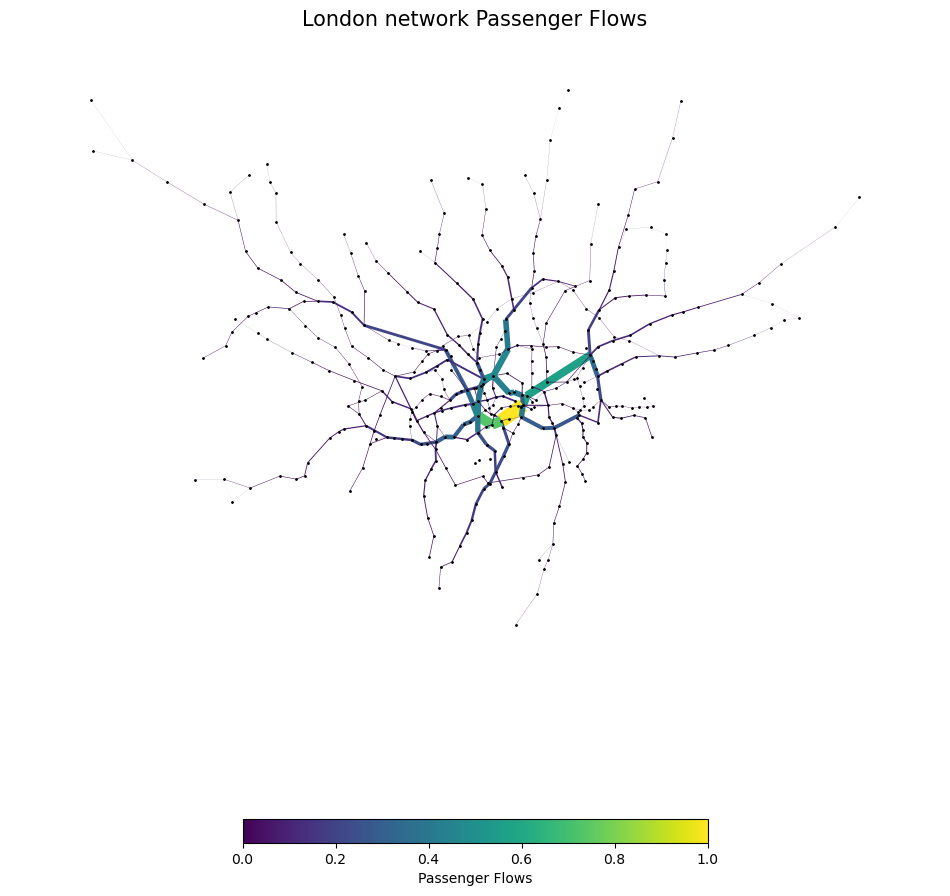

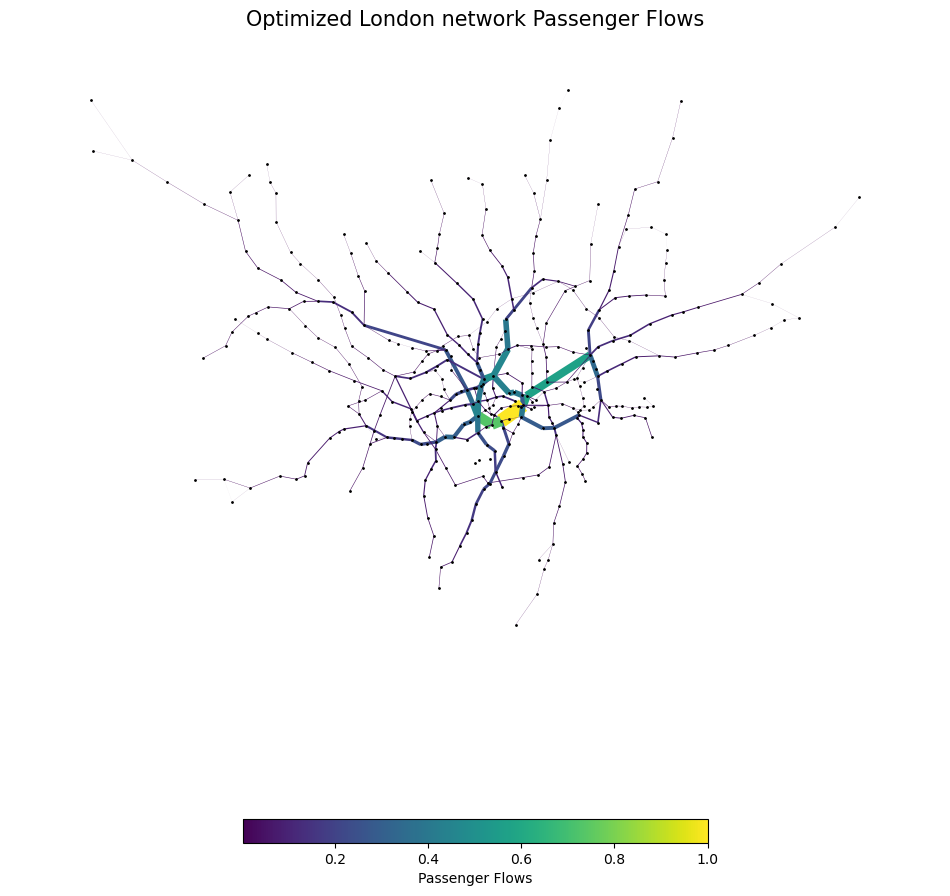

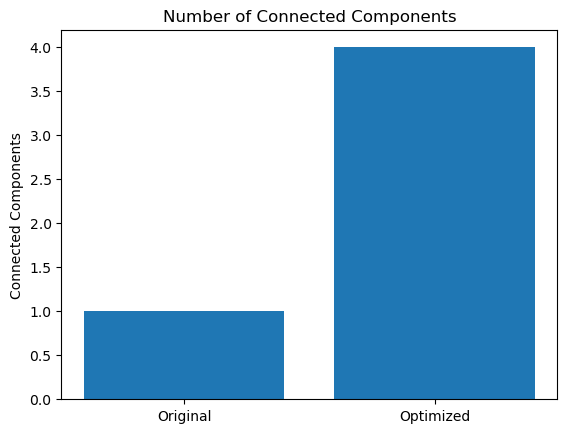

Number of Connected Components:
Original Network: 1.00
Optimized Network: 4.00



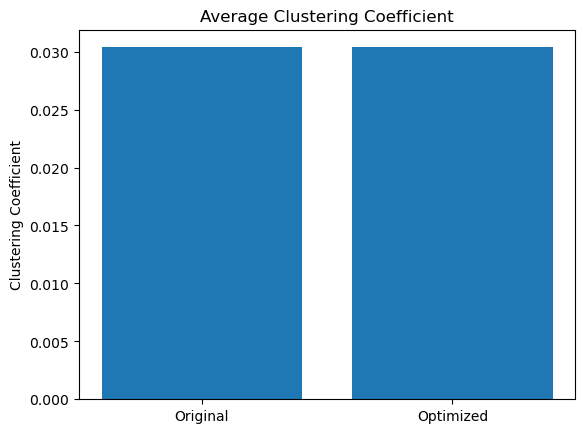

Average Clustering Coefficient:
Original Network: 0.03
Optimized Network: 0.03



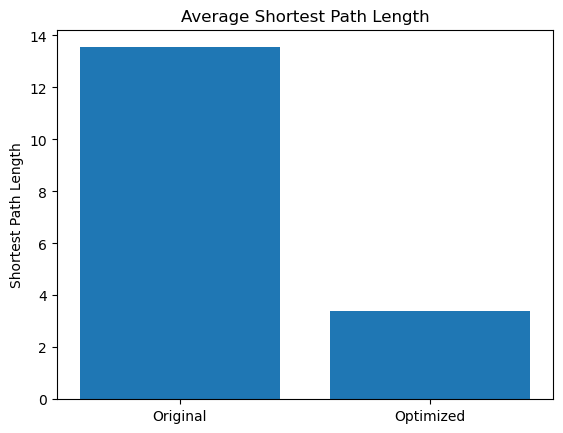

Average Shortest Path Length:
Original Network: 13.55
Optimized Network: 3.39



In [407]:
# Function to plot the network
def plot_graph_flows(graph, title):
    pos = {node: (graph.nodes[node]['x'], graph.nodes[node]['y']) for node in graph.nodes()}
    flows_values = [data['flows'] for _, _, data in graph.edges(data=True)]
    flow_color = [(i[2]['flows'] / max(flows_values)) for i in graph.edges(data=True)]
    flow_width = [(i[2]['flows'] / max(flows_values) * 10) for i in graph.edges(data=True)]

    fig, ax = plt.subplots(figsize=(12, 12))
    edg = nx.draw_networkx_edges(graph, pos, edge_color=flow_color, width=flow_width)
    nx.draw_networkx_nodes(graph, pos, node_color='black', node_size=1)
    plt.colorbar(edg, label="Passenger Flows", orientation="horizontal", shrink=0.5)
    plt.axis("off")
    plt.title(title, fontsize=15)
    plt.show()


# Visualize the original network with passenger flows
plot_graph_flows(G, "London network Passenger Flows")

# Visualize the optimized network with passenger flows
plot_graph_flows(G_optimized, "Optimized London network Passenger Flows")


# Function to create a bar plot of network metrics
def plot_metrics(metrics, labels, title, ylabel):
    plt.bar(labels, metrics)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()


# visualize the network metrics
plot_metrics([num_components, num_components_optimized], ['Original', 'Optimized'], 'Number of Connected Components',
             'Connected Components')
print(
    f'Number of Connected Components:\nOriginal Network: {num_components:.2f}\nOptimized Network: {num_components_optimized:.2f}\n')

plot_metrics([avg_clustering, avg_clustering_optimized], ['Original', 'Optimized'], 'Average Clustering Coefficient',
             'Clustering Coefficient')
print(
    f'Average Clustering Coefficient:\nOriginal Network: {avg_clustering:.2f}\nOptimized Network: {avg_clustering_optimized:.2f}\n')

plot_metrics([avg_shortest_path_length, avg_shortest_path_length_optimized], ['Original', 'Optimized'],
             'Average Shortest Path Length', 'Shortest Path Length')
print(
    f'Average Shortest Path Length:\nOriginal Network: {avg_shortest_path_length:.2f}\nOptimized Network: {avg_shortest_path_length_optimized:.2f}\n')




london_flows：这是一个包含伦敦地铁网络中每条边的客流量数据的Pandas DataFrame。客流量是指在网络中经过某条边的乘客数量。在这个案例中，我们通过分析客流量来了解网络中的拥挤情况以及哪些线路最繁忙。
OD_matrix：这是一个包含伦敦地铁网络中起点和终点站之间的乘客流量数据的Pandas DataFrame。通过分析OD矩阵，我们可以了解乘客的出行需求以及乘客从一个地点到另一个地点的流动情况。
G：这是一个表示伦敦地铁网络的NetworkX图。图中的节点表示地铁站，边表示地铁线路。这个图用于计算和分析地铁网络的拓扑结构和各种指标。
threshold：这是一个用于优化网络的流量阈值。在这个案例中，阈值设置为10，表示我们将移除流量低于10的边。这个参数用于优化网络，通过移除低流量的边来减小拥挤情况。
G_optimized：这是一个优化后的伦敦地铁网络图，从原始网络G中移除了低流量的边。通过对比G和G_optimized的各项指标，我们可以了解优化的效果。
centrality 和 centrality_optimized：这分别是原始网络G和优化后的网络G_optimized的介数中心性指标。介数中心性反映了节点在网络中的重要性，值越高表示节点在网络中的作用越大。在伦敦地铁案例中，它可以帮助我们识别地铁网络中的关键站点。
clustering 和 clustering_optimized：这分别是原始网络G和优化后的网络G_optimized的聚类系数。聚类系数表示网络中节点之间的紧密程度，值越高表示节点之间连接越紧密。在伦敦地铁案例中，它可以帮助我们了解地铁网络的局部连接情况。
avg_shortest_path_length 和 avg_shortest_path_length_optimized：这分别是原始网络G和优化后的网络G_optimized的平均最短路径长度。最短路径长度是指在网络中从一个节点到另一个节点所需经过的最小距离。在伦敦地铁案例中，这个指标可以帮助我们了解乘客在地铁网络中的平均出行时间。
num_components 和 num_components_optimized：这分别是原始网络G和优化后的网络G_optimized的连接组件数量。连接组件是指网络中相互连接的节点组成的子集。在伦敦地铁案例中，连接组件数量可以帮助我们了解地铁网络的连通性。较多的连接组件意味着网络中存在相对独立的部分，可能会导致乘客需要在不同部分之间换乘。优化目标是使连接组件数量降低，从而提高地铁网络的连通性。

以下是对伦敦地铁网络分析结果的解释：
连接组件数量 (Number of Connected Components)：
原始网络中的连接组件数量为1，这意味着整个地铁网络是连通的，没有孤立的部分。优化后的网络中连接组件数量增加到4，表明在移除低流量边的过程中，网络变得不再完全连通，出现了一些相对独立的子网络。这可能导致乘客在这些独立子网络之间换乘时需要花费更多时间。
平均聚类系数 (Average Clustering Coefficient)：
原始网络和优化后的网络的平均聚类系数均为0.03，这意味着优化过程并未改变网络节点间的紧密程度。平均聚类系数较低表明地铁网络的局部连接性较弱，可能需要在关键区域增加新的线路或站点以提高网络的连通性。
平均最短路径长度 (Average Shortest Path Length)：
原始网络的平均最短路径长度为13.55，而优化后的网络显著降低至3.39。这一结果初看上去可能让人觉得优化后的网络表现更好，但实际上这一指标可能产生误导。由于优化后的网络的连接组件数量增加，部分节点可能无法通过原有的最短路径到达，导致计算平均最短路径长度时只考虑了局部的最短路径，从而使得结果显著降低。实际上，在优化后的网络中，乘客可能需要在不同的连接组件之间换乘，这会增加总的出行时间。
综合分析结果来看，优化过程在一定程度上可能导致了网络连通性的降低。在实际应用中，我们需要权衡优化目标（如减少拥挤）与网络连通性的关系，避免过度优化导致的实际出行困难。这些分析结果可以为交通规划者提供有价值的信息，以便在决策过程中调整和优化地铁网络

In [408]:
print(london_flows['flows'].sum())

1542391


In [438]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from scipy.optimize import minimize

# Load data
df = london_flows.copy()


# Define the different cost functions to try
def linear_cost(distance, c):
    return c * distance


def exponential_cost(distance, c):
    return np.exp(-c * distance)


def power_cost(distance, c):
    return np.power(distance, -c)


# Define the gravity model
def gravity_model(distance, a, b, c, cost_function, population, jobs):
    return cost_function(distance, c) * np.power(population, a) * np.power(jobs, b)

# Define the objective function for cross-validation
def objective_function(params, X_train, y_train, X_test, y_test, cost_function):
    a, b, c = params
    y_pred_train = gravity_model(X_train, a, b, c, cost_function, df.loc[train_index, 'scaled_population'], df.loc[train_index, 'scaled_jobs'])
    y_pred_test = gravity_model(X_test, a, b, c, cost_function, df.loc[test_index, 'scaled_population'], df.loc[test_index, 'scaled_jobs'])
    train_error = np.mean(np.square(y_train - y_pred_train))
    test_error = np.mean(np.square(y_test - y_pred_test))
    return (train_error + test_error) / 2



# Perform cross-validation
kf = KFold(n_splits=10, shuffle=True)
best_error = np.inf
best_cost_function = None
best_params = None

params_list = []

for cost_function in [linear_cost, exponential_cost, power_cost]:
    errors = []
    train_test_splits = list(kf.split(df))
    for train_index, test_index in train_test_splits:
        X_train = df.loc[train_index, 'scaled_distance']
        y_train = df.loc[train_index, 'flows']
        X_test = df.loc[test_index, 'scaled_distance']
        y_test = df.loc[test_index, 'flows']
        result = minimize(objective_function, x0=[1, 1, 1], args=(X_train, y_train, X_test, y_test, cost_function))
        params = result.x
        error = result.fun
        params_list.append((cost_function.__name__, params, error))
        errors.append(error)
    avg_error = np.mean(errors)
    if avg_error < best_error:
        best_error = avg_error
        best_cost_function = cost_function
        best_params = params_list[-len(train_test_splits):]

# Select the best set of parameters
best_params.sort(key=lambda x: x[2])
best_params = best_params[0]
best_a, best_b, best_c = best_params[1]

# Print the best result
print('Gravity model parameters:')
print(f"Best cost function: {best_cost_function.__name__}")
print(f"{kf.n_splits} fold for cross-validation")
print(f"Best error: {best_params[2]}")
print(f"Best parameters: a={best_a:.3f}, b={best_b:.3f}, c={best_c:.3f}")

# Print the meanings of a, b, and c
print("\nMeaning of the parameters:")
print(f"a: controls the effect of population on the flows")
print(f"b: controls the effect of jobs on the flows")
print(f"c: controls the impact of distance on the flows through the cost function")

Gravity model parameters:
Best cost function: exponential_cost
10 fold for cross-validation
Best error: 13626.378076031004
Best parameters: a=0.564, b=0.005, c=1.000

Meaning of the parameters:
a: controls the effect of population on the flows
b: controls the effect of jobs on the flows
c: controls the impact of distance on the flows through the cost function


R2 score: -0.038


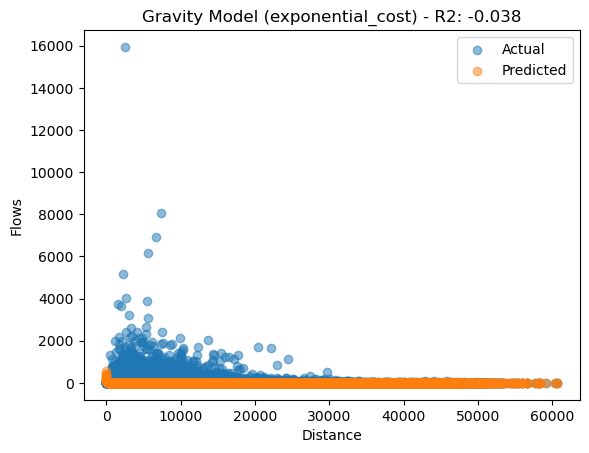

In [439]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Get the best model's predictions on the entire dataset
y_pred = gravity_model(df['scaled_distance'], best_a, best_b, best_c, best_cost_function, df['scaled_population'], df['scaled_jobs'])

# Calculate R2 score
r2 = r2_score(df['flows'], y_pred)
print(f"R2 score: {r2:.3f}")

# Visualize the results
plt.scatter(df['scaled_distance'], df['flows'], label='Actual', alpha=0.5)
plt.scatter(df['scaled_distance'], y_pred, label='Predicted', alpha=0.5)
plt.xlabel('Distance')
plt.ylabel('Flows')
plt.title(f"Gravity Model ({best_cost_function.__name__}) - R2: {r2:.3f}")
plt.legend()
plt.show()


### IV.1. Scenario A: 50% decrease in jobs at Canary Wharf
assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the calibrated parameter , compute the new flows for scenario A. Make sure the number of commuters is conserved, and explain how you ensured this.

In [473]:
# Identify Canary Wharf in the dataset
canary_wharf_index = df[df['station_destination'] == 'Canary Wharf'].index

# Make a copy of the original dataset and reduce jobs by 50% at Canary Wharf
df_scenario_A = df.copy()
df_scenario_A.loc[canary_wharf_index, 'scaled_jobs'] *= 0.5

# Scale the updated jobs column
df_scenario_A['scaled_jobs'] = scaler_jobs.transform(df_scenario_A['scaled_jobs'].values.reshape(-1, 1))

# Compute the new flows using the updated jobs data and the calibrated parameters
y_pred_scenario_A = gravity_model(df_scenario_A['scaled_distance'], best_a, best_b, best_c, best_cost_function, df_scenario_A['scaled_population'], df_scenario_A['scaled_jobs'])

# Normalize the new flows to conserve the number of commuters
total_original_flows = df['flows'].sum()
total_new_flows = y_pred_scenario_A.sum()
normalization_factor = total_original_flows / total_new_flows
y_pred_scenario_A_normalized = y_pred_scenario_A * normalization_factor

# Update the dataset with the new normalized flows
df_scenario_A['new_flows'] = y_pred_scenario_A_normalized

# Print the results for Canary Wharf
print("Scenario A: 50% decrease in jobs at Canary Wharf")
print(f"Total flows: {df_scenario_A['new_flows'].sum():.0f}")
print(f"Total new flows to Canary Wharf: {df_scenario_A[df_scenario_A['station_destination'] == 'Canary Wharf']['new_flows'].sum():.0f}, decreased by {100 - df_scenario_A[df_scenario_A['station_destination'] == 'Canary Wharf']['new_flows'].sum() / df[df['station_destination'] == 'Canary Wharf']['flows'].sum() * 100:.0f}%")
print(f"Total new flows from Canary Wharf: {df_scenario_A[df_scenario_A['station_origin'] == 'Canary Wharf']['new_flows'].sum():.0f}, increased by {df_scenario_A[df_scenario_A['station_origin'] == 'Canary Wharf']['new_flows'].sum() / df[df['station_origin'] == 'Canary Wharf']['flows'].sum() * 100 - 100:.0f}%")
df_scenario_A[df_scenario_A['station_destination'] == 'Canary Wharf'][['station_origin', 'station_destination', 'flows', 'new_flows']]
# df_scenario_A[['station_origin', 'station_destination', 'flows', 'new_flows']]



Scenario A: 50% decrease in jobs at Canary Wharf
Total flows: 1542391
Total new flows to Canary Wharf: 7237, decreased by 88%
Total new flows from Canary Wharf: 15532, increased by 6%


,station_origin,station_destination,flows,new_flows
3,Abbey Road,Canary Wharf,1,10.028913
126,Acton Town,Canary Wharf,57,21.888741
348,Aldgate,Canary Wharf,1,23.742817
595,Aldgate East,Canary Wharf,3,25.641837
817,All Saints,Canary Wharf,67,12.017914
...,...,...,...,...
60595,Wood Green,Canary Wharf,64,32.122462
60838,Wood Lane,Canary Wharf,0,11.517238
61062,Woodford,Canary Wharf,192,28.216247
61294,Woodside Park,Canary Wharf,42,19.027139
